# Data Picking and Classification on Smaller Datasets

This Notebook is to try on training on a smaller dataset with fewer number of labels.

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.popular_models import PopularModels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from data.dataset import MultiLabelDataset
from tqdm import tqdm
from tools.tools import get_data, load_data, tokenize
from typing import Tuple
from models.lstm import LSTM

In [3]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], test_data['caption']), ignore_index=True)

In [4]:
print(f"Number of training instances: {train_data.shape[0]}")
print(f"Number of testing instances:  {test_data.shape[0]}")

Number of training instances: 30000
Number of testing instances:  10000


In [5]:
# get only class 2, 4 and 5
filtered_data = train_data[(train_data['class 2'] == 1) | (train_data['class 4'] == 1) | (train_data['class 5'] == 1)]

# remove other classes
classes_not_dropped = [2, 4, 5]
for i in range(train_data.shape[1] - 2):
	if ((i + 1) not in classes_not_dropped):
		filtered_data = filtered_data.drop(f'class {i + 1}', axis=1)

print(filtered_data)

        image_id                                            caption  class 2  \
6          6.jpg          a big airplane flying in the big blue sky      0.0   
7          7.jpg          a man riding a motor bike across a forest      0.0   
17        17.jpg               a small airplane that is on a runway      0.0   
40        40.jpg  man on dirt bike with a redheaded woman in his...      0.0   
41        41.jpg  people playing tennis on the court on a sunny day      1.0   
...          ...                                                ...      ...   
29960  29960.jpg  a motorcycle that is missing parts like a rear...      0.0   
29967  29967.jpg     a person on a bike rides next to a city street      1.0   
29971  29971.jpg  a group of people waiting to get off the ferry...      1.0   
29980  29980.jpg  airplane is docked at the airport so passenger...      0.0   
29995  29995.jpg  a picture of a truck that is in the middle of ...      1.0   

       class 4  class 5  
6          0.

## Image Classification Model

In [6]:
# define the image transformation: currently following resnet18
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # converts images to [0, 1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [7]:
# initialize the dataset
train_dataset = MultiLabelDataset(
    csv_file=filtered_data,
    root_dir='../dataset/data/',
    vectorizer=None,
    transform=transform,
    use_caption_vec=False,
    caption_vec=None,
    is_test=False,
)

BATCH_SIZE=16

# load the dataset into batches 
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [8]:
N_OUT = 3

model = PopularModels(
    choice='regnet_x_1_6gf',
    pretrained=True,
    freeze=True,
    n_out=N_OUT,
).get_model()

# define hyperparameters
EPOCHS = 20
THRESHOLD = 0.5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


### Note

The metric used currently is accuracy.

In [9]:
train_losses = []
train_accs = []
for epoch in range(EPOCHS):

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for _, images, _, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			images = images.to('cuda')
			labels = labels.to('cuda')

		optimizer.zero_grad()
		y_pred = model(images)

		# backward
		loss = loss_fn(y_pred, labels)
		loss.backward()

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > THRESHOLD).int()

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_dataloader))
	train_accs.append(n_correct / n_total)

	print("Epoch {:d}, Train Loss: {:.7f}, Train Accuracy: {:.3f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training:   0%|          | 0/213 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 1 Training: 100%|██████████| 213/213 [00:14<00:00, 14.86it/s]


Epoch 1, Train Loss: 0.4365742, Train Accuracy: 35.984%


Epoch 2 Training: 100%|██████████| 213/213 [00:13<00:00, 15.54it/s]


Epoch 2, Train Loss: 0.3309047, Train Accuracy: 59.011%


Epoch 3 Training: 100%|██████████| 213/213 [00:13<00:00, 15.48it/s]


Epoch 3, Train Loss: 0.3055341, Train Accuracy: 63.604%


Epoch 4 Training: 100%|██████████| 213/213 [00:13<00:00, 15.47it/s]


Epoch 4, Train Loss: 0.2896503, Train Accuracy: 66.549%


Epoch 5 Training: 100%|██████████| 213/213 [00:14<00:00, 15.07it/s]


Epoch 5, Train Loss: 0.2748268, Train Accuracy: 68.257%


Epoch 6 Training: 100%|██████████| 213/213 [00:13<00:00, 15.32it/s]


Epoch 6, Train Loss: 0.2669459, Train Accuracy: 69.464%


Epoch 7 Training: 100%|██████████| 213/213 [00:13<00:00, 15.37it/s]


Epoch 7, Train Loss: 0.2626050, Train Accuracy: 70.024%


Epoch 8 Training: 100%|██████████| 213/213 [00:13<00:00, 15.24it/s]


Epoch 8, Train Loss: 0.2598040, Train Accuracy: 70.465%


Epoch 9 Training: 100%|██████████| 213/213 [00:13<00:00, 15.34it/s]


Epoch 9, Train Loss: 0.2578969, Train Accuracy: 71.231%


Epoch 10 Training: 100%|██████████| 213/213 [00:13<00:00, 15.60it/s]


Epoch 10, Train Loss: 0.2465549, Train Accuracy: 71.879%


Epoch 11 Training: 100%|██████████| 213/213 [00:14<00:00, 14.75it/s]


Epoch 11, Train Loss: 0.2415784, Train Accuracy: 73.086%


Epoch 12 Training: 100%|██████████| 213/213 [00:14<00:00, 14.58it/s]


Epoch 12, Train Loss: 0.2487761, Train Accuracy: 72.409%


Epoch 13 Training: 100%|██████████| 213/213 [00:13<00:00, 15.51it/s]


Epoch 13, Train Loss: 0.2426958, Train Accuracy: 72.968%


Epoch 14 Training: 100%|██████████| 213/213 [00:13<00:00, 15.50it/s]


Epoch 14, Train Loss: 0.2379573, Train Accuracy: 72.821%


Epoch 15 Training: 100%|██████████| 213/213 [00:13<00:00, 15.59it/s]


Epoch 15, Train Loss: 0.2428159, Train Accuracy: 73.793%


Epoch 16 Training: 100%|██████████| 213/213 [00:13<00:00, 15.74it/s]


Epoch 16, Train Loss: 0.2403756, Train Accuracy: 73.174%


Epoch 17 Training: 100%|██████████| 213/213 [00:13<00:00, 15.50it/s]


Epoch 17, Train Loss: 0.2285548, Train Accuracy: 74.264%


Epoch 18 Training: 100%|██████████| 213/213 [00:14<00:00, 14.68it/s]


Epoch 18, Train Loss: 0.2394012, Train Accuracy: 73.822%


Epoch 19 Training: 100%|██████████| 213/213 [00:14<00:00, 15.09it/s]


Epoch 19, Train Loss: 0.2277600, Train Accuracy: 74.588%


Epoch 20 Training: 100%|██████████| 213/213 [00:14<00:00, 15.14it/s]

Epoch 20, Train Loss: 0.2254899, Train Accuracy: 75.442%


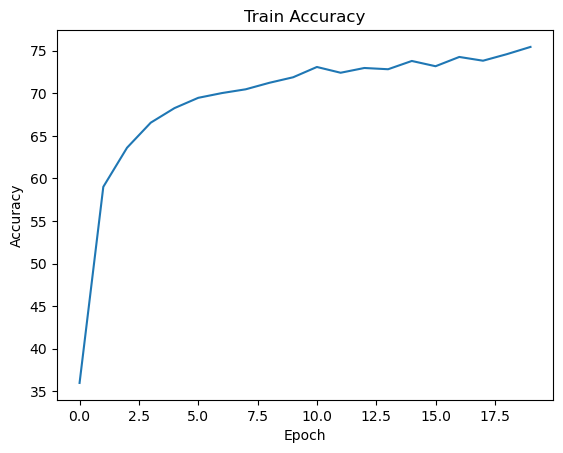

In [11]:
new_train_accs = []
for i, train_acc in enumerate(train_accs):
    new_train_accs.append(train_acc.item() * 100)

plt.title("Train Accuracy")
plt.plot(new_train_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Text Classification Model

### Using Count Vectorizer

In [12]:
# Count Vectorizer
vectorizer = CountVectorizer(lowercase=True)
vectorizer.fit(for_nlp_data)

X_train_vec = vectorizer.transform(filtered_data['caption'])
X_test_vec = vectorizer.transform(test_data['caption'])

# the size of vocabulary is 8075
print(X_train_vec.shape)
print(X_test_vec.shape)

(3396, 8075)
(10000, 8075)


In [13]:
X_train_tensor = torch.from_numpy(X_train_vec.todense()).int()
X_test_tensor = torch.from_numpy(X_test_vec.todense()).int()
y_train_tensor = torch.from_numpy(np.array(filtered_data.iloc[:, 2:]))
y_test_tensor = torch.from_numpy(np.array(test_data.iloc[:, 2:]))

### Instead of Count Vectorizer, Let's use Tokenization

- Reference: [Sentiment Analysis using LSTM PyTorch](https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch)
- Another Helpful Reference: [LSTM Text Classification - PyTorch](https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch/notebook)

In [15]:
X_train_vec, vocab = tokenize(filtered_data['caption'])
print(X_train_vec.shape)
print(len(vocab))

# to tensor
X_train_tensor = torch.from_numpy(X_train_vec).int()

Max Sentence Length: 16
(3396, 16)
2109


### Continue with Training

In [16]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16,
    shuffle=True
)

In [19]:
epochs = 20
threshold = 0.5

model = LSTM(
    no_layers=1,
    vocab_size=len(vocab), # extra 1 is already included, usually for padding
    embedding_dim=64,
    hidden_dim=256,
    output_dim=3,
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


In [20]:
clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
for epoch in range(epochs):

	# initialize the hidden state
	hidden = model.init_hidden(batch_size=BATCH_SIZE)

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for captions, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			captions = captions.to('cuda')
			labels = labels.to('cuda')

		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		model.zero_grad()
		y_pred, hidden = model(captions, hidden)

		# backward
		loss = loss_fn(y_pred.squeeze(), labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > threshold).int()
		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_loader))
	train_accs.append(n_correct / n_total)

	print("Epoch {:d}, Train Loss: {:.9f}, Train Accuracy: {:.7f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training: 100%|██████████| 213/213 [00:00<00:00, 401.31it/s]


Epoch 1, Train Loss: 0.697561338, Train Accuracy: 0.5889282%


Epoch 2 Training: 100%|██████████| 213/213 [00:00<00:00, 482.93it/s]


Epoch 2, Train Loss: 0.693163052, Train Accuracy: 0.0000000%


Epoch 3 Training: 100%|██████████| 213/213 [00:00<00:00, 484.04it/s]


Epoch 3, Train Loss: 0.693149417, Train Accuracy: 0.0000000%


Epoch 4 Training: 100%|██████████| 213/213 [00:00<00:00, 493.19it/s]


Epoch 4, Train Loss: 0.693157551, Train Accuracy: 0.0883392%


Epoch 5 Training: 100%|██████████| 213/213 [00:00<00:00, 484.45it/s]


Epoch 5, Train Loss: 0.693160817, Train Accuracy: 0.0000000%


Epoch 6 Training: 100%|██████████| 213/213 [00:00<00:00, 492.38it/s]


Epoch 6, Train Loss: 0.693150580, Train Accuracy: 0.0000000%


Epoch 7 Training: 100%|██████████| 213/213 [00:00<00:00, 464.43it/s]


Epoch 7, Train Loss: 0.681501848, Train Accuracy: 10.9246178%


Epoch 8 Training: 100%|██████████| 213/213 [00:00<00:00, 466.64it/s]


Epoch 8, Train Loss: 0.643729607, Train Accuracy: 46.0541840%


Epoch 9 Training: 100%|██████████| 213/213 [00:00<00:00, 424.35it/s]


Epoch 9, Train Loss: 0.625605382, Train Accuracy: 53.9163780%


Epoch 10 Training: 100%|██████████| 213/213 [00:00<00:00, 390.04it/s]


Epoch 10, Train Loss: 0.615006777, Train Accuracy: 65.6654892%


Epoch 11 Training: 100%|██████████| 213/213 [00:00<00:00, 494.70it/s]


Epoch 11, Train Loss: 0.597418723, Train Accuracy: 84.2461777%


Epoch 12 Training: 100%|██████████| 213/213 [00:00<00:00, 496.30it/s]


Epoch 12, Train Loss: 0.592885087, Train Accuracy: 86.0129623%


Epoch 13 Training: 100%|██████████| 213/213 [00:00<00:00, 471.64it/s]


Epoch 13, Train Loss: 0.589535559, Train Accuracy: 87.2202606%


Epoch 14 Training: 100%|██████████| 213/213 [00:00<00:00, 466.84it/s]


Epoch 14, Train Loss: 0.587401190, Train Accuracy: 87.6030655%


Epoch 15 Training: 100%|██████████| 213/213 [00:00<00:00, 466.47it/s]


Epoch 15, Train Loss: 0.584894637, Train Accuracy: 88.7220306%


Epoch 16 Training: 100%|██████████| 213/213 [00:00<00:00, 473.66it/s]


Epoch 16, Train Loss: 0.583425808, Train Accuracy: 89.3698502%


Epoch 17 Training: 100%|██████████| 213/213 [00:00<00:00, 475.00it/s]


Epoch 17, Train Loss: 0.582263479, Train Accuracy: 89.7821045%


Epoch 18 Training: 100%|██████████| 213/213 [00:00<00:00, 473.76it/s]


Epoch 18, Train Loss: 0.581164756, Train Accuracy: 90.1649094%


Epoch 19 Training: 100%|██████████| 213/213 [00:00<00:00, 480.18it/s]


Epoch 19, Train Loss: 0.580434241, Train Accuracy: 90.3710327%


Epoch 20 Training: 100%|██████████| 213/213 [00:00<00:00, 474.23it/s]

Epoch 20, Train Loss: 0.579382506, Train Accuracy: 90.7832794%


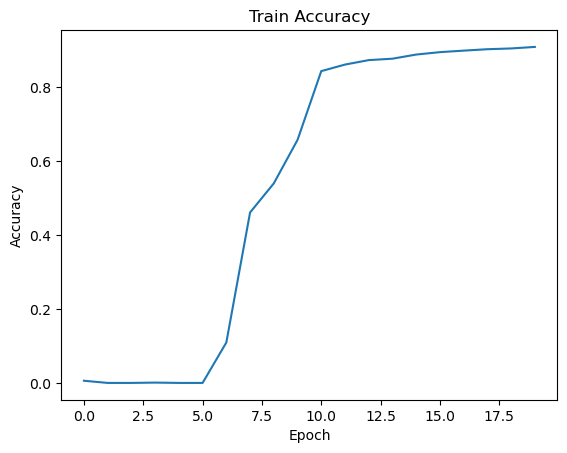

: 

In [21]:
new_train_accs = []
for i, train_acc in enumerate(train_accs):
    new_train_accs.append(train_acc.item())
    # print(train_acc.item())

plt.title("Train Accuracy")
plt.plot(new_train_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()